In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import folium
import numpy as np
import seaborn as sn
import os
from shapely.geometry import Point
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('ggplot')

In [2]:
# Connect to Oracle
eng = nivapy.da.connect()

Connection successful.


# MARTINI - identify river input datasets

The marine models used in MARTINI require terrestrial inputs from the major rivers draining to Skagerrak. This notebook explores various different river chemistry datasets to see what's available.

Requirements for the data have been outlined by Phil (see e-mail received 19.09.2018 at 20.14):

 * Annual, monthly and daily nutrient concentrations in $mmol/m^3$. We are mostly interested in daily values, but monthly or even annual estimates could be used initially
 
 * The time period of interest is 2015 to 2017
 
 * For nitrogen: $NO_3$, $NH_4$, $DON$ and $PON$. Note that $TOTN$ is not used directly in the marine models but would nevertheless be useful
 
 * For phosphorus: $PO_4$, $DOP$ and $POP$. As with N, $TOTP$ is not used directly, but will be useful
 
 * $DOC$/$TOC$, plus any other data on organic carbon 
 
 * Any spectral data relating to $CDOM$ e.g. UV absorbance or spectral slope
 
 * Daily flows in $m^3/s$ (**already done by Andre**)
 
## 1. Rivers of interest

The rivers of interest are listed by Andre (see e-mail received 09.11.2018 at 15.15). Andre already has daily flow values for these locations, so the main aim here to is identify as much compatible water chemistry as possible. We need data from Norway, Sweden and Denmark:

 * **Norway**. Data for 25 major rivers (vassdragområder 001 to 025)
 
 * **Sweden**. Data for 5 major rivers (available from SMHI's [Vattenwebb](https://www.smhi.se/klimatdata/hydrologi/vattenwebb))
 
 * **Denmark**. Data for 9 rivers. Currently not sure where to find this, but have e-mailed Ciaran for suggestions
 
Andre's list of rivers is shown below. Note that he has divided some river outflows into two parts (because they connect to different cells in the marine model). There are therefore 42 rivers in the list, but we only need to identify chemistry data for **39 distinct rivers**.

In [4]:
# Read Andre's list of rivers
riv_xlsx = r'../tidied_data_series/martini_river_outlets.xlsx'
riv_df = pd.read_excel(riv_xlsx, sheet_name='rivers')

riv_df

,martini_id,station_name,resa_id,vannmiljo_id,mvm_id,lat,lon,martini_code
0,34,Vigsø bukt,NaN,NaN,NaN,57.0998,8.7573,dmca003
1,35,West side of Nord-Jylland - Liver Å,NaN,NaN,NaN,57.5330,9.8866,dmca004
2,36,Hirtshals-Skagen - Uggerby Å,NaN,NaN,NaN,57.5922,10.1498,dmca005
3,37,Skagen- Lyngsaa strand,NaN,NaN,NaN,57.5922,10.1498,dmca006
4,38,East side of Nord-Jylland,NaN,NaN,NaN,57.6539,10.4793,dmca007
5,39,Limfjord,NaN,NaN,NaN,56.9761,10.3320,dmca008
6,40,Mariagerfjord,NaN,NaN,NaN,56.7114,10.3531,dmca009
7,41,Gudenå,NaN,NaN,NaN,56.6023,10.3463,dmca010
8,42,Læsø,NaN,NaN,NaN,57.2817,11.1491,dmca011
9,7,Haldenvassdraget,29830.0,001-38541,NaN,59.1187,11.3697,nmca001


## 2. Available water chemistry

### 2.1. Norway

The most relevant Norwegian datasets are likely to be those from the RID/Elveovervåkingprogrammet. It is possible to identify RID stations for 24 of the 25 Norwegian rivers in Andre's list (see the `'resa_id'` column in the table above), but note that many of these stations have not been actively monitored by NIVA since the early 2000s. In some cases, monitoring data have been collected more recently by other organisations and these data are available via the [Vannmiljø website](https://vannmiljo.miljodirektoratet.no/). In principle, all the NIVA data should be available here too, so the easiest option - at least initially - is to download as much as possible from Vannmiljø. Vannmiljø station IDs for the nearest stations with good water chemistry are also listed in the table above.

**There are three rivers in Andre's dataset with limited water chemistry data**: Årungelva (`'ncma005'`) and Sageneelve (`'nmca010'`) have essentially no usable data at all since 2000, while Hølenelva (`'ncma004'`) has no TOC record.

**Note:** Vannmiljø does not seem to have a public web API and accessing the data manually is slow/tedious (especially because the amount of data that can be downloaded in one go is limited). However, purely by chance, I think I've discovered a bug in the website that makes it possible to download much larger volumes of data than intended by the developers. For future reference:

 * From the main web page, choose ***Jeg vil > Søk i vannlokaliteter***, then leave all the otpions blank and click ***Søk***. This returns a list of all the stations in the database
 
 * The number of selections from this list is limited but, if you just choose ***Overfør kriterier til vannregistreringsøk*** from the upper panel (not from above the data table), it seems you can access the *entire* Vannmiljø dataset :-)
 
I have narrowed the search to only include N, P and C data (all species) for the period from 01/01/2000 to the present, and then exported *all* the Vannmiljø data for the whole of Norway. This produces a fairly large Excel file, but it's much easier to get everything in a single step than to manually download a separate file for each site.

#### 2.1.1. Filter and tidy Vannmiljø data

The code below takes a while to run as the Excel file is large. The results are saved in CSV format at the end, so this cell should not need to be re-run unless the Vannmiljø export is updated.

In [ ]:
## Read Vannmiljø dataset
#vm_xlsx = r'../../../vannmiljo_export/vannmiljo_n_p_c_all.xlsx'
#wc_df = pd.read_excel(vm_xlsx, sheet_name='VannmiljoEksport')
#
## Filter to stns of interest
#vm_stns = list(riv_df['vannmiljo_id'].dropna())
#wc_df = wc_df.query('Vannlokalitet_kode in @vm_stns')
#
## Rename and tidy
#wc_df['vassnr'] = wc_df['Vannlokalitet_kode'].str.split('-').str[0]
#wc_df['utm_zone'] = 33
#wc_df['Tid_provetak'] = pd.to_datetime(wc_df['Tid_provetak'], format='%Y-%m-%d %H:%M:%S')
#wc_df['Verdi'] = wc_df['Verdi'].astype(str).str.replace(',', '.').astype(float)
#wc_df.rename({'Vannlokalitet':'station_name',
#              'Parameter_id':'parameter',
#              'Tid_provetak':'sample_date',
#              'Ovre_dyp':'depth1',
#              'Nedre_dyp':'depth2',
#              'Operator':'flag',
#              'Verdi':'value',
#              'Enhet':'unit',
#              'UTM33 Ost (X)':'easting',
#              'UTM33 Nord (Y)':'northing'},
#             inplace=True, axis=1)
#
## Filter cols
#cols = ['vassnr', 'station_name', 'easting', 'northing', 'utm_zone',
#        'sample_date', 'depth1', 'depth2', 'parameter', 'flag', 
#        'value', 'unit']
#wc_df = wc_df[cols]
#wc_df.reset_index(inplace=True, drop=True)
#
## Convert UTM to dd
#wc_df = nivapy.spatial.utm_to_wgs84_dd(wc_df, 
#                                       east='easting', 
#                                       north='northing', 
#                                       zone='utm_zone')
#
## Filter cols
#cols = ['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 
#        'depth1', 'depth2', 'parameter', 'flag', 'value', 'unit']
#wc_df = wc_df[cols]
#
## Save as csv for faster processing
#vm_csv = r'../../../vannmiljo_export/vannmiljo_n_p_c_martini.csv'
#wc_df.to_csv(vm_csv, index=False, encoding='utf-8')

In [5]:
# Read tidied Vannmiljø data back from csv for speed
vm_csv = r'../../../vannmiljo_export/vannmiljo_n_p_c_martini.csv'
wc_df = pd.read_csv(vm_csv)
del wc_df['flag']

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

Checking of the Vannmiljø dataset reveals that at least some of the NIVA data are missing. I will therefore extract all the NIVA data for the RID sites since 2000 and combine it with what is in Vannmiljø. This will produce duplicates for some station-parameter-date combinations, but these can be averaged to create a more complete dataset. 

In [6]:
# RESA stations of interest
stn_list = list(riv_df['resa_id'].dropna())

# Pars of interest (TOT-N, NO3, TOC, TOT-P, NH4, PO4, DOC)
par_list = [4, 5, 6, 24, 49, 285, 879]

# Date range
st_dt = '2000-01-01'
end_dt = '2017-12-31'

# Get data from RESA
res_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_list,
                                                       par_list,
                                                       st_dt,
                                                       end_dt,
                                                       eng,
                                                       drop_dups=True,
                                                       lod_flags=False)

# Datetimes to dates
res_df['sample_date'] = pd.to_datetime(res_df['sample_date']).dt.date
del res_df['station_code'], res_df['station_name']

# Melt
res_df = res_df.melt(id_vars=['station_id', 'sample_date', 'depth1', 'depth2'],
                     var_name='par_unit')

# Split par and unit
res_df['parameter'], res_df['unit'] = res_df['par_unit'].str.split('_', 1).str
del res_df['par_unit']
res_df.dropna(subset=['value'], inplace=True)

# Join vassnrs from Andre's data
res_df = pd.merge(res_df, riv_df[['resa_id', 'martini_code']],
                  how='left',
                  left_on='station_id', 
                  right_on='resa_id')

# Extract vassnr
res_df['vassnr'] = res_df['martini_code'].str[-3:].astype(int)

# Join station metadata from Vannmiljø
chem_met_df = wc_df[['vassnr', 'station_name', 'lon', 'lat']].copy().drop_duplicates()
res_df = pd.merge(res_df, chem_met_df,
                  how='left', on='vassnr')

# Gets cols of interest
res_df = res_df[['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 
                 'depth1', 'depth2', 'parameter', 'value', 'unit']]

res_df.head()

,vassnr,station_name,lon,lat,sample_date,depth1,depth2,parameter,value,unit
0,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-01-08,0,0,DOC,2.8,mg/L C
1,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-02-05,0,0,DOC,2.4,mg/L C
2,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-02-05,0,0,DOC,2.4,mg/L C
3,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-03-05,0,0,DOC,2.3,mg/L C
4,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-04-04,0,0,DOC,2.7,mg/L C


The NIVA data from RESA can now be combined with the data from Vannmiljø.

In [7]:
# Combine with RESA data
wc_df = pd.concat([wc_df, res_df], axis=0, sort=False)

wc_df.head()

,vassnr,station_name,lon,lat,sample_date,depth1,depth2,parameter,value,unit
0,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-08-11,NaN,NaN,N-TOT,710.0,µg/l N
1,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-09-08,NaN,NaN,N-TOT,850.0,µg/l N
2,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-10-14,NaN,NaN,N-TOT,960.0,µg/l N
3,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-11-17,NaN,NaN,N-TOT,1100.0,µg/l N
4,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-04-16,NaN,NaN,P-PO4-F,6.0,µg/l P


#### 2.1.2. Compare water chemistry locations to river outflows

In [8]:
# Get unique stations from Vannmiljø data
nor_chem_df = wc_df[['vassnr', 'station_name', 'lon', 'lat']].drop_duplicates()

# Get Norway outlets from Andre's data
nor_out_df = riv_df.loc[riv_df['martini_code'].str.startswith('n')]

# Setup map
map1 = folium.Map(location=[59, 10.8],
                  zoom_start=7,
                  tiles='Stamen Terrain')

# Create feature groups
fg_q = folium.FeatureGroup(name='River outlets')
fg_wc = folium.FeatureGroup(name='Water chemsitry stations')
fgs = [fg_q, fg_wc]

# Add clickable markers for sites
cols = ['green', 'blue']
for df_idx, df in enumerate([nor_out_df, nor_chem_df]):
    for idx, row in df.iterrows():  
        folium.Marker([row['lat'], row['lon']], 
                      popup=row['station_name'],
                      icon=folium.Icon(color=cols[df_idx])).add_to(fgs[df_idx])
    map1.add_child(fgs[df_idx])

# Turn on layer control
map1.add_child(folium.map.LayerControl())

map1

#### 2.1.3. Tidy/aggregate data

The Vannmiljø and NIVA databases use different parameter anmes and units, and there are multiple values for the same station-date-parameter combinations. The code below **averages duplicates** and performas the following aggregations:

 * RESA2 parameters names are changed to match those used by Vannmiljø
 
 * Units are standardised

 * There is very little data for `'P-TOT-F'`, `'POC'` or `'PON'` (not enough to be useful) so these are removed
 
 * I have aggregated `'P-PO4-F'`, `'P-PO4'`, `'P-ORTO-F'` and `'P-ORTO'` into a single category named `'SRP'`

In [9]:
# Copy raw data
wc_df2 = wc_df.copy()

# Remove unusual pars with v. limited data
wc_df2 = wc_df2.query('parameter not in ("N-SNOX", "P-TOT-F", "PON", "POC")')

# Rename pars to match Vannmiljø
par_dict = {'P-PO4-F':'SRP',
            'P-PO4':'SRP',
            'P-ORTO':'SRP',
            'P-ORTO-F':'SRP',
            'NH4-N':'N-NH4',
            'NO3-N':'N-NO3',
            'PO4-P':'SRP',
            'TOTN':'N-TOT',
            'TOTP':'P-TOT'}
wc_df2['parameter'].replace(par_dict, inplace=True)

## Rename units
unit_dict = {'µg/l N':'µg/l',
             'µg/l P':'µg/l',
             'mg/l C':'mg/l',
             'mg/L C':'mg/l', 
             'mg C/l':'mg/l'}
wc_df2['unit'].replace(unit_dict, inplace=True)

# Merge cols
wc_df2['par_unit'] = wc_df2['parameter'] + '_' + wc_df2['unit']
del wc_df2['depth1'], wc_df2['depth2'], wc_df2['parameter'], wc_df2['unit']

# Average duplicates
idx_cols = ['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
wc_df2 = wc_df2.groupby(idx_cols).mean().reset_index()

# Save to CSV
csv_path = r'../tidied_data_series/martini_norway_chem_tidy.csv'
wc_df2.to_csv(csv_path, index=False, encoding='utf-8')

wc_df2.head()

,vassnr,station_name,lon,lat,sample_date,par_unit,value
0,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NH4_µg/l,21.0
1,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NO3_µg/l,574.0
2,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-TOT_µg/l,936.0
3,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,SRP_µg/l,1.0
4,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,TOC_mg/l,7.1


#### 2.1.4. Plot raw time series

The code below creates a matrix plot showing the raw data available at each location. The resulting plots are available [here](https://github.com/JamesSample/martini/tree/master/plots/raw_data) and an example is shown below. Some key points to note:

 * NH4 and SRP concentrations are often close to the detection limit, which makes them unsuitable for use in standard regression analysis (see below)
 
 * NO3 concentrations are (unsurprisingly) closely correlated with Tot-N
 
 * Since 2000, we have reasonable records for Tot-N, Tot-P and TOC for 22 out of 25 Norwegian sites (the exceptions being vassdragområde 004, which has no TOC data, and vassdragområder 005 and 010, which have no data at all)

In [10]:
# Plots of raw data
for vass in wc_df2['vassnr'].unique():
    # Get stn data
    df = wc_df2.query('vassnr == @vass')
    
    # Restructure
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Plot
    df.plot(subplots=True, 
            layout=(2,4), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)
    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/raw_data/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close()    

Raw data for vassdragområde 25.


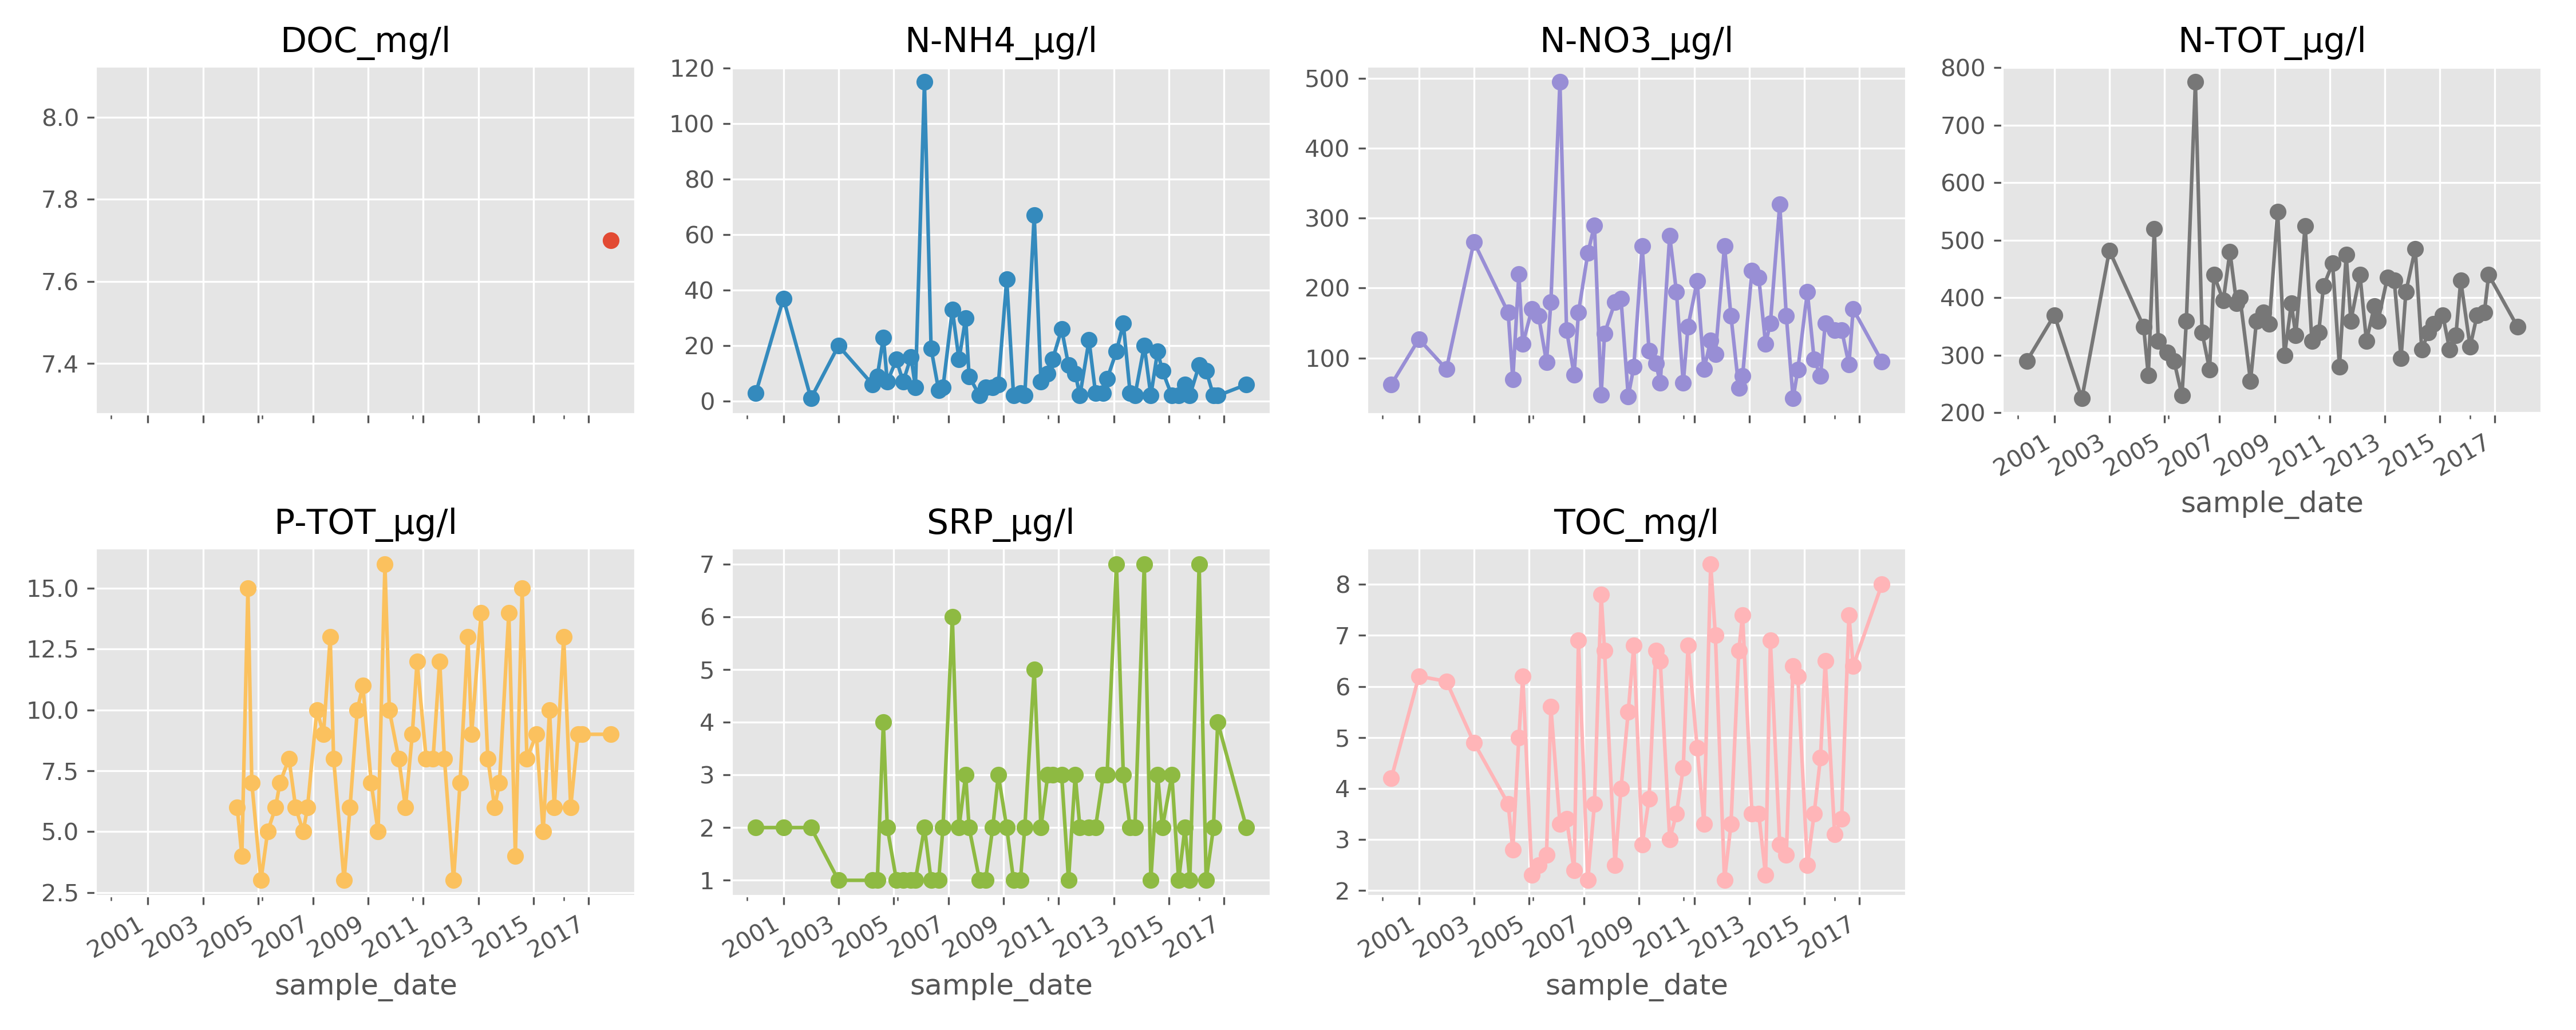

In [11]:
# Show example image
print ('Raw data for vassdragområde %s.' % vass)
Image(png_path)

#### 2.1.5. Simple linear regression against flow

Ultimately, we would like to generate daily resolution time series for the marine models. We have daily flow data for all sites, so one option is to consider concentration-discharge plots to see if a relationship existis for predicting concentrations from discharge. In general, such relationships are not straightforward, so I don't expect this to be very successful, but it's worth a go initially. The usual approach is to consider simple OLS regression of $log(C)$ versus $log(Q)$.

As noted above, concentrations for SRP and NH4 are typically close to the limit of detection, so simple OLS regression is not really appropriate. Instead, I will perform concentration-flow regressions for just Tot-N, Tot-P and TOC. If this works, I can also derive regressions (based on all the data pooled together?) between e.g. Tot-N & NH4, and SRP & Tot-P etc. which will probably be more robust than using flow with these parameters directly. This approach has the additional advantage that almost all sites have reasonable Tot-N, Tot-P and TOC records, whereas data for the other chemical parameters are limited. Performing site-specific C-Q regressions and "overall" C-C regressions should therefore ensure that each regression has a reasonable amount of data.

The code below creates one matrix plot for Tot-N, Tot-P and TOC at each site. The plots are available [here](https://github.com/JamesSample/martini/tree/master/plots/flow_conc_reg) and an example is shown below.

In [12]:
# Simple OLS regression against flow
for vass in wc_df2['vassnr'].unique():
    # Skip sites with no data
    if vass not in (5, 10):
        # Get stn data
        df = wc_df2.query('vassnr == @vass')
        
        # Set values equal to 0 to NaN (zeros cause log issues, and no lab 
        # method can actually report 0)
        df[df==0] = np.nan

        # Get RESA stn ID
        mar_cd = 'nmca%03d' % vass
        resa_id = riv_df.query('martini_code == @mar_cd')['resa_id'].iloc[0]

        # Get flow data from NIVABASE
        q_df = nivapy.da.extract_resa_discharge(resa_id,
                                                '2000-01-01',
                                                '2017-12-31',
                                                eng,
                                                plot=False)

        # Restructure chem
        df = df.sort_values(['sample_date', 'par_unit'])
        df.set_index(idx_cols, inplace=True)
        df = df.unstack('par_unit').reset_index().sort_values('sample_date')
        df.index = df['sample_date']
        del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
        df.columns = df.columns.get_level_values(1)

        # Get list of chem cols
        if vass == 4:
            # No TOC
            chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l']
        else:
            chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l', 'TOC_mg/l']

        # Join to Q
        df = df.join(q_df, how='left')

        # Setup plot
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
        axes = axes.flatten()

        # Regression plots for each parameter
        for idx, col in enumerate(chem_cols):
            # Regression plot
            sn.regplot(x=np.log10(df['flow_m3/s']), 
                       y=np.log10(df[col]), 
                       data=df, 
                       ax=axes[idx])
            axes[idx].set_title(col)
            axes[idx].set_xlabel('log[Flow ($m^3/s$)]')
            axes[idx].set_ylabel('log[%s]' % col)

        plt.tight_layout()       

        # Save png
        png_path = r'../plots/flow_conc_reg/vassnr_%03d.png' % vass
        plt.savefig(png_path, dpi=300)
        plt.close()  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will 

Regression plots for vassdragområde 25.


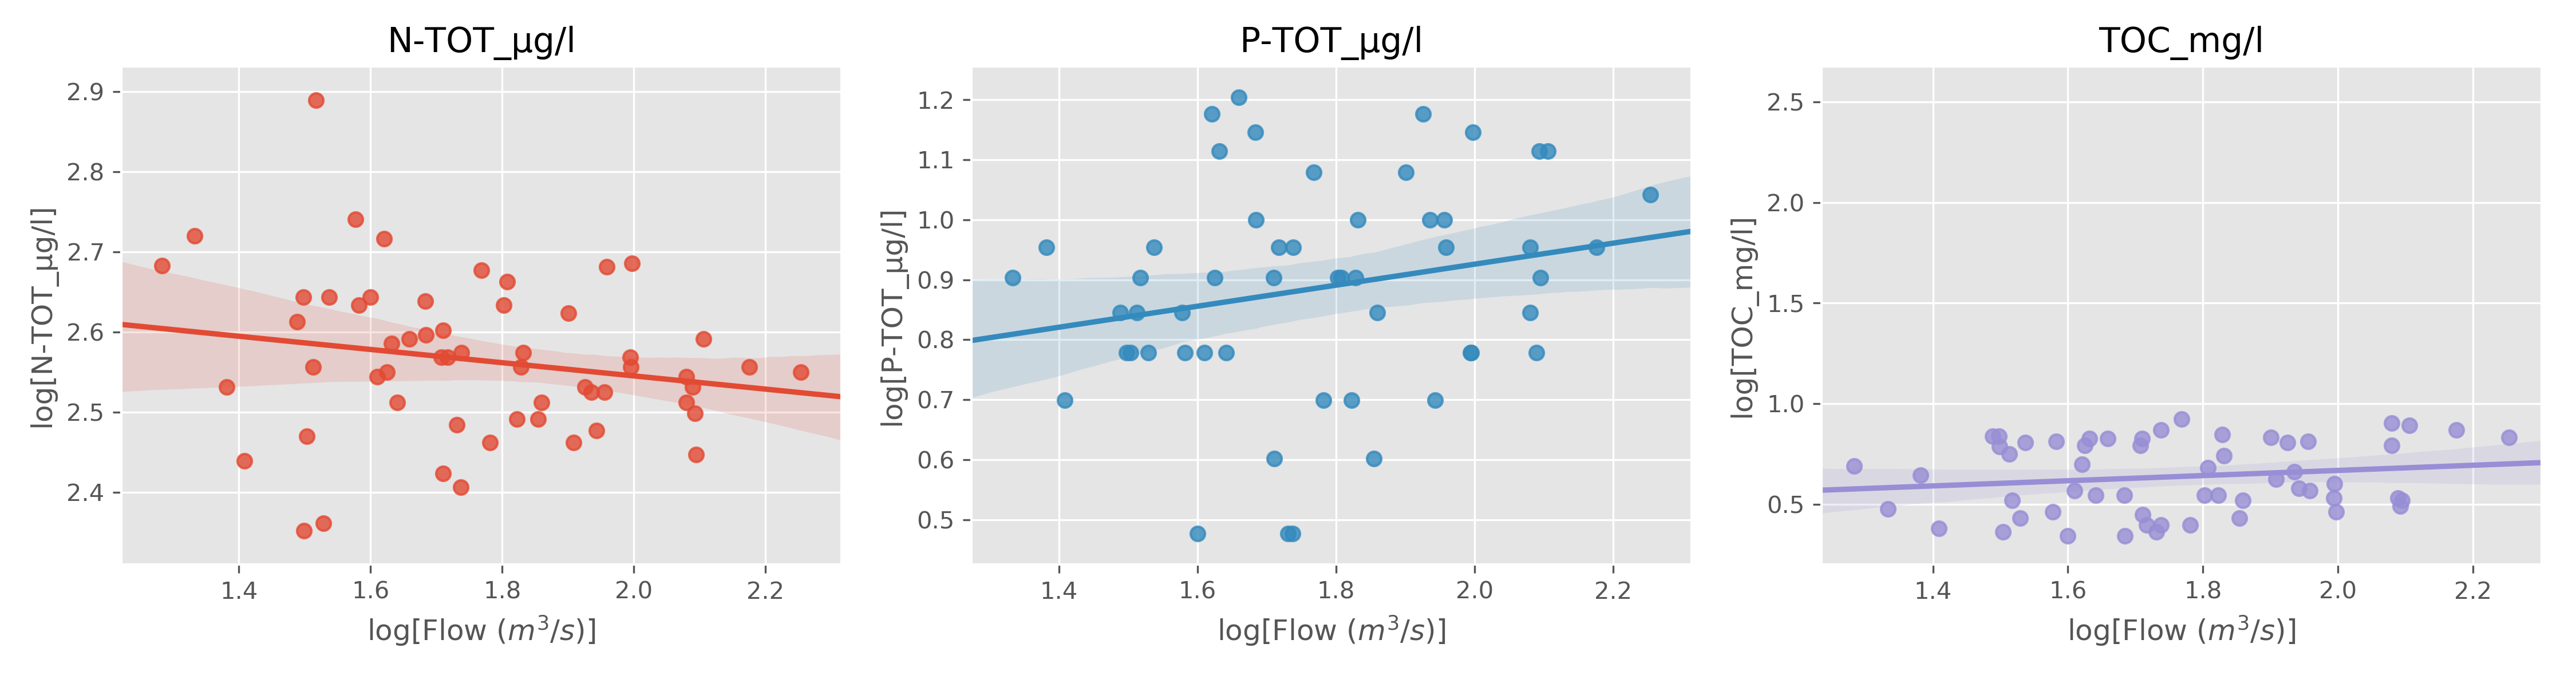

In [13]:
# Show example image
print ('Regression plots for vassdragområde %s.' % vass)
Image(png_path)

In some cases the regression results are poor (as above), but in several examples they're better than expected. If we need to generate daily inputs for the marine models, then I don't think we have any better option than using these equations, as flow is the only variable measured reliably with daily resolution for all the major catchments.

#### 2.1.6. Simple linear regression between concentrations

The code below pools all the data for all 23 sites (22 for C) and derives regression relationships between the following variables

 * NH4 vs. Tot-N
 * NO3 vs. Tot-N
 * SRP vs. Tot-P
 * DOC vs. TOC
 
The C-Q relationships from above can be used to derive daily Tot-N, Tot-P and TOC concentrations from the dishcarge data, and then these relationships can be used to estimate NH4, NO3, SRP and DOC.

Note that the code below filters out one obviously contaminated sample with Tot-P > 3000 ug/l.

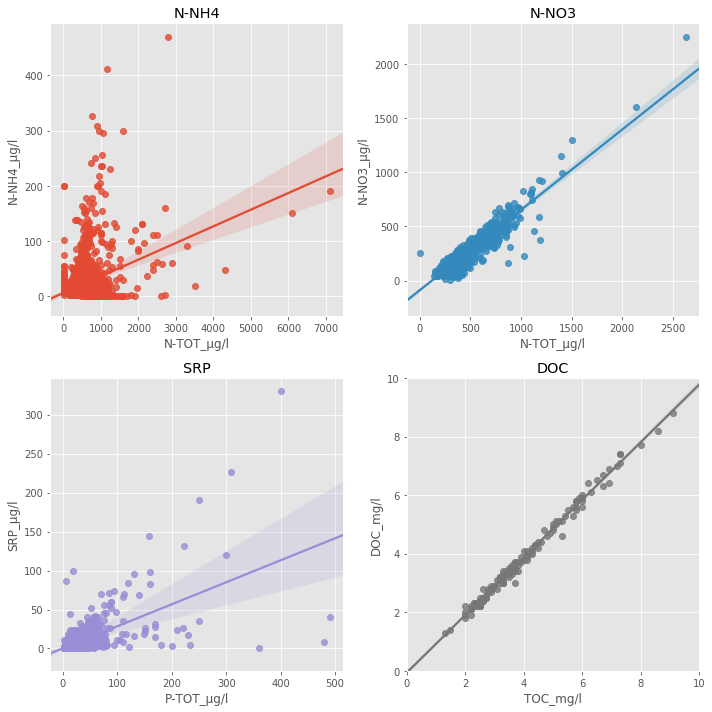

In [14]:
# Restructure chem
df = wc_df2.copy()
df = df.sort_values(['vassnr', 'sample_date', 'par_unit'])
df.set_index(idx_cols, inplace=True)
df = df.unstack('par_unit').reset_index().sort_values(['vassnr', 'sample_date'])
del df['station_name'], df['lon'], df['lat']
df.columns = df.columns.get_level_values(1)
cols = list(df.columns)
cols[:2] = ['vassnr', 'sample_date']
df.columns = cols

# Filter obviously contaminated P sample
df = df[df['P-TOT_µg/l']<3000]

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = axes.flatten()

# NH4 vs Tot-N
sn.regplot(x='N-TOT_µg/l', 
           y='N-NH4_µg/l', 
           data=df, 
           ax=axes[0])
axes[0].set_xlabel('N-TOT_µg/l')
axes[0].set_ylabel('N-NH4_µg/l')
axes[0].set_title('N-NH4')

# NO3 vs Tot-N
sn.regplot(x='N-TOT_µg/l', 
           y='N-NO3_µg/l', 
           data=df, 
           ax=axes[1])
axes[1].set_xlabel('N-TOT_µg/l')
axes[1].set_ylabel('N-NO3_µg/l')
axes[1].set_title('N-NO3')

# SRP vs Tot-P
sn.regplot(x='P-TOT_µg/l', 
           y='SRP_µg/l', 
           data=df, 
           ax=axes[2])
axes[2].set_xlabel('P-TOT_µg/l')
axes[2].set_ylabel('SRP_µg/l')
axes[2].set_title('SRP')

# DOC vs TOC
sn.regplot(x='TOC_mg/l', 
           y='DOC_mg/l', 
           data=df, 
           ax=axes[3])
axes[3].set_xlabel('TOC_mg/l')
axes[3].set_ylabel('DOC_mg/l')
axes[3].set_title('DOC')
axes[3].set_xlim(0,10)
axes[3].set_ylim(0,10)

plt.tight_layout()

The regressions for NO3 and DOC look very good, but those for NH4 and SRP are less convincing. This is partly because values for these parameters are often very close to the detection limit, and partly because the relationships just seem to vary a lot from site to site. I have tried performing these regressions separately for each site and, in some locations, (e.g. Glomma), the SRP relationship is very good: it's the "classic" result of $SRP \approx 0.6*TotP$. However, elsewhere the relationship is either poor or significnatly different. In most cases, we do not have enough data to perform the regressions separately for each site, so I'll continue with the relationships above, even though they are sometimes poor.

### 2.2. Sweden

##### Water chemistry

Water chemistry data for Sweden are available from the [MVM database](http://miljodata.slu.se/mvm). After a bit of searching, it looks as though the following stations will be most appropriate for the river outlets in Andre's file:

 * Göta älv, Alelyckan
 * Bäveån Uddevalla
 * Örekilsälven Munkedal
 * Enningdalsälv N.Bullaren
 * Strömsån, utflöde

[This link](http://miljodata.slu.se/mvm/Query?sites=43,31,32,35,42954&products=6&parameters=Q,C_org,DOC,NH4_N,NO2_NO3_N,NO2_N,NO3_N,N_org,P,Part-P,PO4_P,PO4_P_F,TOC,Tot_N,Tot_N_F,Tot_N_ps,Tot_N_summa,Tot_N_TNb,Tot_P,Tot_P_F&startdate=2000-01-01&enddate=2018-10-01) should make it possible to repeate the manual export of data for these locations in the future. Alternatively, I have recently created a Python module called [MVM Python](https://github.com/NIVANorge/mvm_python), which is designed to make it easier to automatically download MVM data via their web API.

**Note:** The Göta älv splits into two parts above Göteborg and flows into different cells in the marine model. I can't find good water chemistry data upstream of this bifurcation; the best data come from lower down the southern branch of the river at Alelyckan. **I will assume these concentrations are represenative of both branches of the river**.  

##### Discharge

Modelled, bias-corrected discharge data for Sewden is available via E-HYPE [here](https://vattenwebb.smhi.se/modelarea/). This makes it easy to click on any location in Sweden and download daily discharge time series (from 1990 to 2017) comparable to that supplied for Norway by NVE. I have downloaded discharge datasets for the five chemistry monitoring locations listed above. Note that for Göta älv I've downloaded two flow time series: one close to the chemistry monitoring station at Alelyckan, which will be used in the regressions, and another on the northern outflow branch, which may be useful for the marine modelling.

#### 2.2.1. Filter and tidy MVM data

The code below does some basic tudying and saves the results to CSV. This cell does not need to be re-run unless the MVM export is updated.

In [ ]:
## Read Vannmiljø dataset
#mvm_xlsx = r'../../../mvm_export/slu_mvm_data.xlsx'
#wc_df = pd.read_excel(mvm_xlsx, sheet_name='Mätvärden Vattenkemi')
#
## Rename and tidy
#wc_df['Provdatum'] = pd.to_datetime(wc_df['Provdatum'], format='%Y-%m-%d')
#wc_df['Värde/Koncentration'] = wc_df['Värde/Koncentration'].str.replace('<', '')
#wc_df['Värde/Koncentration'] = wc_df['Värde/Koncentration'].astype(str).str.replace(',', '.').astype(float)
#wc_df.rename({'Stationsnamn':'station_name',
#              'MD-MVM Id':'mvm_id',
#              'Parameter':'parameter',
#              'Provdatum':'sample_date',
#              'Min provdjup (m)':'depth1',
#              'Max provdjup (m)':'depth2',
#              'Värde/Koncentration':'value',
#              'Enhet':'unit',
#              'Stationskoordinat N/X':'northing',
#              'Stationskoordinat E/Y':'easting'},
#             inplace=True, axis=1)
#
## Filter cols
#cols = ['mvm_id', 'station_name', 'easting', 'northing',
#        'sample_date', 'depth1', 'depth2', 'parameter',
#        'value', 'unit']
#wc_df = wc_df[cols]
#wc_df.reset_index(inplace=True, drop=True)
#
## Convert from spatial co-ords from SWEREF-99-TM (= EPSG 3006) to dd
#geometry = [Point(xy) for xy in zip(wc_df.easting, wc_df.northing)]
#crs = {'init': 'epsg:3006'}
#gdf = gpd.GeoDataFrame(wc_df, crs=crs, geometry=geometry)
#gdf = gdf.to_crs({'init': 'epsg:4326'})
#gdf['lat'] = gdf.geometry.y
#gdf['lon'] = gdf.geometry.x
#del gdf['geometry'], gdf['easting'], gdf['northing']
#wc_df = pd.DataFrame(gdf)
#
## Filter cols
#cols = ['mvm_id', 'station_name', 'lon', 'lat', 'sample_date', 
#        'depth1', 'depth2', 'parameter', 'value', 'unit']
#wc_df = wc_df[cols]
#
## Save as csv for faster processing
#mvm_csv = r'../../../mvm_export/slu_mvm_data.csv'
#wc_df.to_csv(mvm_csv, index=False, encoding='utf-8')

In [15]:
# Read tidied MVM data back from csv for speed
mvm_csv = r'../../../mvm_export/slu_mvm_data.csv'
wc_df = pd.read_csv(mvm_csv)

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

wc_df.head()

,mvm_id,station_name,lon,lat,sample_date,depth1,depth2,parameter,value,unit
0,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",NH4-N,36.0,µg/l
1,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",NO2+NO3-N,430.0,µg/l
2,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",PO4-P,21.0,µg/l
3,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",TOC,9.3,mg/l
4,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",Tot-N_ps,917.0,µg/l


#### 2.2.2. Compare water chemistry locations to river outflows

In [16]:
# Get unique stations from MVM data
swe_chem_df = wc_df[['mvm_id', 'station_name', 'lon', 'lat']].drop_duplicates()

# Get Norway outlets from Andre's data
swe_out_df = riv_df.loc[riv_df['martini_code'].str.startswith('s')]

# Setup map
map2 = folium.Map(location=[58.3, 11],
                  zoom_start=8,
                  tiles='Stamen Terrain')

# Create feature groups
fg_q = folium.FeatureGroup(name='River outlets')
fg_wc = folium.FeatureGroup(name='Water chemsitry stations')
fgs = [fg_q, fg_wc]

# Add clickable markers for sites
cols = ['green', 'blue']
for df_idx, df in enumerate([swe_out_df, swe_chem_df]):
    for idx, row in df.iterrows():  
        folium.Marker([row['lat'], row['lon']], 
                      popup=row['station_name'],
                      icon=folium.Icon(color=cols[df_idx])).add_to(fgs[df_idx])
    map2.add_child(fgs[df_idx])

# Turn on layer control
map2.add_child(folium.map.LayerControl())

map2

#### 2.2.3. Tidy/aggregate data

The following aggregations/simplifications have been made to the MVM data:

 * Averaging values with duplicated station-date-parameter combinations
 * I have aggregated `'Tot-N_ps'`, `'Tot-N_summa'` and `'Tot-N_TNb'` into a single category named `'N-TOT'`
 * The unit for `'Tot-N_summa'` has been changed to `'µg/l'` from `'µg/l N'`
 * I have filtered out data for Org-N and NO2-N as it is very limited (not enough to be useful). NO2-N values are also so low as to be negligible
 * I have renamed `'PO4-P'` as `'SRP'`, just for consistency with the analysis of the Norwegian data
 * I have renamed `'NO2+NO3-N'` as `'NO3-N'`, again for consistency (and because NO2-N is so low)
 * I have changed all the parameter names to be consistent with those in Vannmiljø. This makes it easier to re-use code from the analysis above

In [17]:
# Copy raw data
wc_df2 = wc_df.copy()

# Remove pars with v. limited data
wc_df2 = wc_df2.query('parameter not in ("Org-N", "NO2-N")')

# Rename parameters
par_dict = {'Tot-N_ps':'N-TOT', 
            'Tot-N_summa':'N-TOT', 
            'Tot-N_TNb':'N-TOT',
            'PO4-P':'SRP',
            'NO2+NO3-N':'N-NO3',
            'NH4-N':'N-NH4',
            'Tot-P':'P-TOT'}
wc_df2['parameter'].replace(par_dict, inplace=True)

# Rename units
unit_dict = {'µg/l N':'µg/l'}
wc_df2['unit'].replace(unit_dict, inplace=True)

# Merge cols
wc_df2['par_unit'] = wc_df2['parameter'] + '_' + wc_df2['unit']

# Average duplicates
idx_cols = ['mvm_id', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
wc_df2 = wc_df2.groupby(idx_cols).mean().reset_index()

# Save to CSV
csv_path = r'../tidied_data_series/martini_sweden_chem_tidy.csv'
wc_df2.to_csv(csv_path, index=False, encoding='utf-8')

wc_df2.head()

,mvm_id,station_name,lon,lat,sample_date,par_unit,value
0,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,N-NH4_µg/l,36.0
1,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,N-NO3_µg/l,430.0
2,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,N-TOT_µg/l,917.0
3,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,P-TOT_µg/l,68.0
4,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,SRP_µg/l,21.0


#### 2.2.4. Plot raw time series

The code below creates a matrix plot showing the raw data available at each location. The resulting plots are available [here](https://github.com/JamesSample/martini/tree/master/plots/raw_data) and an example is shown below.

In [18]:
# Plots of raw data
for mvm_id in wc_df2['mvm_id'].unique():
    # Get stn data
    df = wc_df2.query('mvm_id == @mvm_id')
    
    # Restructure
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['mvm_id'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Plot
    df.plot(subplots=True, 
            layout=(2,4), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)
    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/raw_data/mvm_id_%05d.png' % mvm_id
    plt.savefig(png_path, dpi=300)
    plt.close()

Raw data for MVM ID 42954.


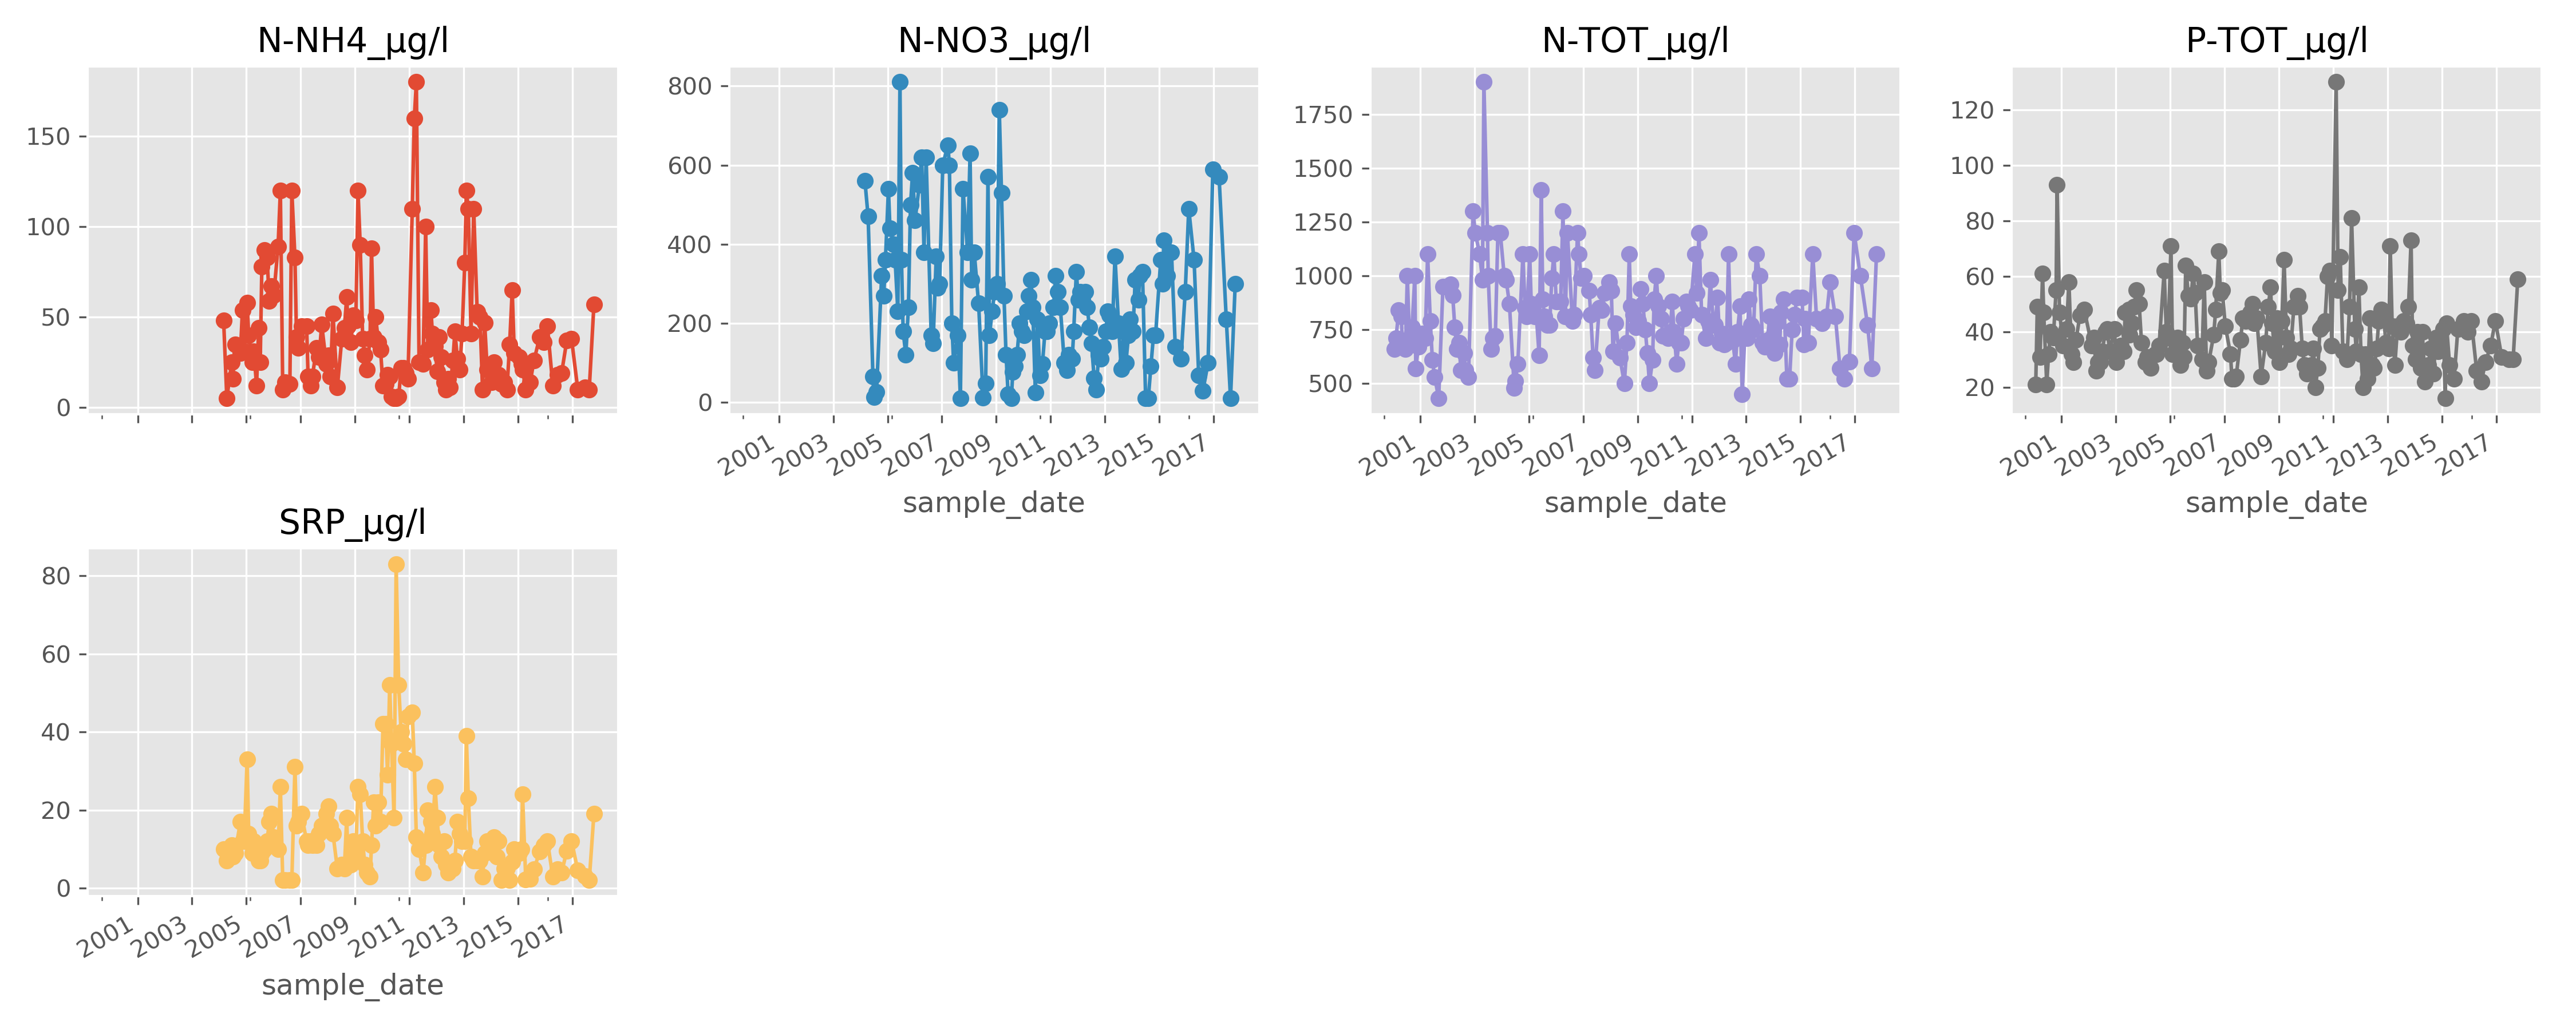

In [19]:
# Show example image
print ('Raw data for MVM ID %s.' % mvm_id)
Image(png_path)

#### 2.2.5. Simple linear regression against flow

##### Process flow data

In [20]:
# Dict linking file names to MVM IDs
mvm_dict = {'gota_alv_north':np.nan,
            'gota_alv_south':43,
            'bavean':31,
            'orekilsalven':32,
            'enningdalsalven':35,
            'stromsan':42954}

# Flow folder
flow_fold = '../../../vattenwebb_export'

# Loop over files
df_list = []
for fname in mvm_dict.keys():
    # Read data
    xl_path = os.path.join(flow_fold, '%s.xls' % fname)
    df = pd.read_excel(xl_path, 
                       sheet_name='Dygnsvärden',
                       usecols='A,C',
                       skiprows=2,
                       header=None,
                       names=['date', 'flow_m3/s'])
    df.dropna(how='any', inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['flow_m3/s'] = df['flow_m3/s'].astype(float)
    
    # Add MVM ID
    df['mvm_id'] = mvm_dict[fname]
    
    # Add to results
    df_list.append(df)

# Combine
swe_q_df = pd.concat(df_list, axis=0, sort=False)
swe_q_df = swe_q_df[['mvm_id', 'date', 'flow_m3/s']]

# Save
out_csv = r'../tidied_data_series/martini_sweden_flow_tidy.csv'
swe_q_df.to_csv(out_csv, index=False, encoding='utf-8')

swe_q_df.head()

,mvm_id,date,flow_m3/s
1,NaN,1999-01-01,535.0
2,NaN,1999-01-02,549.0
3,NaN,1999-01-03,525.0
4,NaN,1999-01-04,539.0
5,NaN,1999-01-05,562.0


##### Perform regressions

In [21]:
# Simple OLS regression against flow
for mvm_id in wc_df2['mvm_id'].unique():
    # Get stn data
    df = wc_df2.query('mvm_id == @mvm_id')

    # Restructure chem
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['mvm_id'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)

    # Get list of chem cols
    if mvm_id == 42954:
        # No TOC
        chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l']
    else:
        chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l', 'TOC_mg/l']

    # Join to Q
    q_df = swe_q_df.query('mvm_id == @mvm_id').copy()
    q_df.set_index('date', inplace=True)
    del q_df['mvm_id']
    df = df.join(q_df, how='left')
    
    # Setup plot
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    axes = axes.flatten()

    # Regression plots for each parameter
    for idx, col in enumerate(chem_cols):
        # Regression plot
        sn.regplot(x=np.log10(df['flow_m3/s']), 
                   y=np.log10(df[col]), 
                   data=df, 
                   ax=axes[idx])
        axes[idx].set_title(col)
        axes[idx].set_xlabel('log[Flow ($m^3/s$)]')
        axes[idx].set_ylabel('log[%s]' % col)

    plt.tight_layout()       

    # Save png
    png_path = r'../plots/flow_conc_reg/mvm_id_%05d.png' % mvm_id
    plt.savefig(png_path, dpi=300)
    plt.close()  

Regression plots for MVM ID 42954.


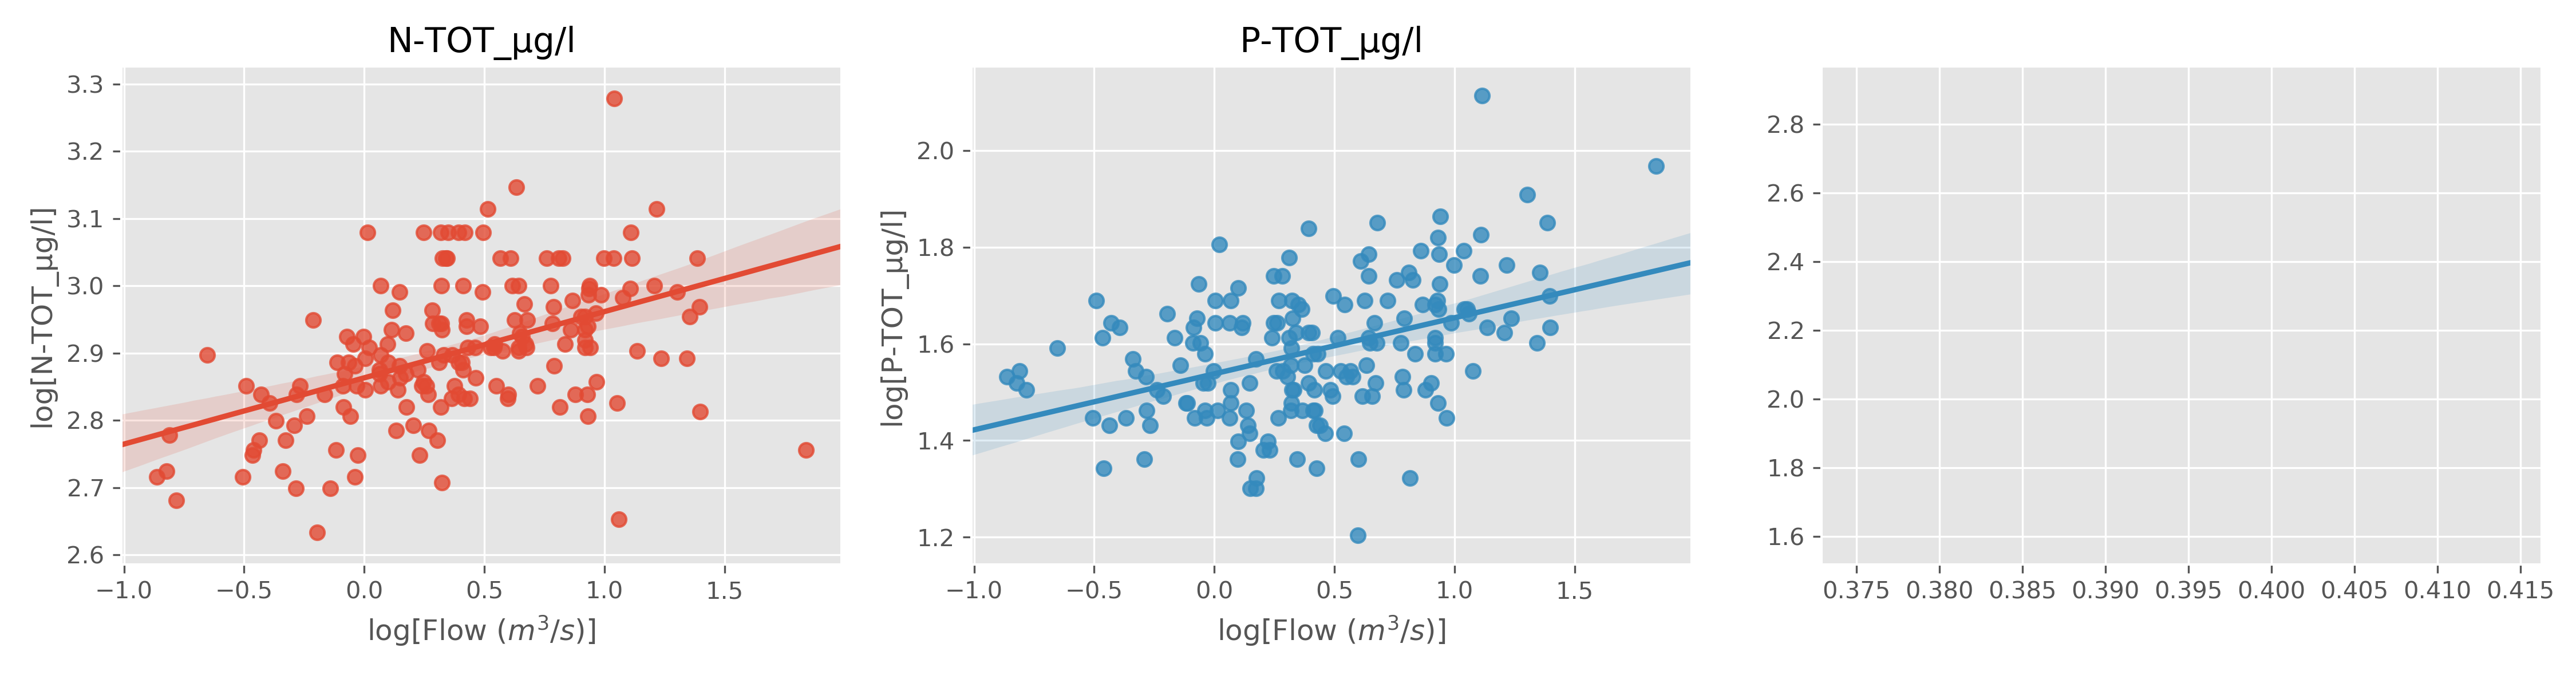

In [22]:
# Show example image
print ('Regression plots for MVM ID %s.' % mvm_id)
Image(png_path)

#### 2.2.6. Simple linear regression between concentrations

The code below pools all the data for all 5 sites and derives regression relationships between the following variables

 * NH4 vs. Tot-N
 * NO3 vs. Tot-N
 * SRP vs. Tot-P

Note that there is no DOC data for the Swedish sites (in Scandinavia it's pretty normal to assume that DOC equals TOC). For the work here, I'll just take the results from the Norwegian data i.e. $DOC = 0.97*TOC$.

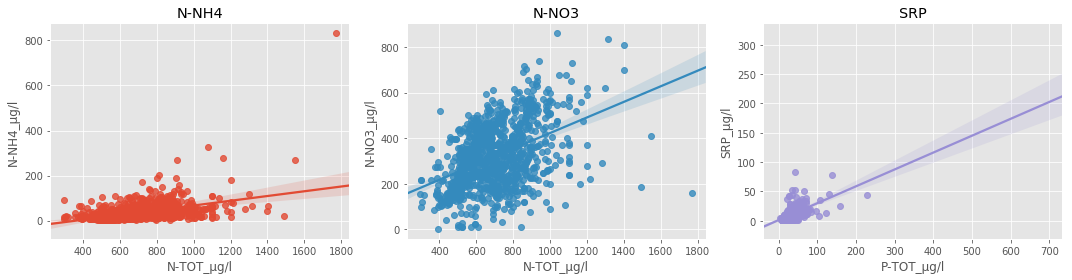

In [23]:
# Restructure chem
df = wc_df2.copy()
df = df.sort_values(['mvm_id', 'sample_date', 'par_unit'])
df.set_index(idx_cols, inplace=True)
df = df.unstack('par_unit').reset_index().sort_values(['mvm_id', 'sample_date'])
del df['station_name'], df['lon'], df['lat']
df.columns = df.columns.get_level_values(1)
cols = list(df.columns)
cols[:2] = ['mvm_id', 'sample_date']
df.columns = cols

# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
axes = axes.flatten()

# NH4 vs Tot-N
sn.regplot(x='N-TOT_µg/l', 
           y='N-NH4_µg/l', 
           data=df, 
           ax=axes[0])
axes[0].set_xlabel('N-TOT_µg/l')
axes[0].set_ylabel('N-NH4_µg/l')
axes[0].set_title('N-NH4')

# NO3 vs Tot-N
sn.regplot(x='N-TOT_µg/l', 
           y='N-NO3_µg/l', 
           data=df, 
           ax=axes[1])
axes[1].set_xlabel('N-TOT_µg/l')
axes[1].set_ylabel('N-NO3_µg/l')
axes[1].set_title('N-NO3')

# SRP vs Tot-P
sn.regplot(x='P-TOT_µg/l', 
           y='SRP_µg/l', 
           data=df, 
           ax=axes[2])
axes[2].set_xlabel('P-TOT_µg/l')
axes[2].set_ylabel('SRP_µg/l')
axes[2].set_title('SRP')

plt.tight_layout()